# 1️⃣ Set-up YOLOE

----------

##Check GPU availability

In [ ]:
!nvidia-smi

Wed Jul  9 07:12:35 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   35C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
!pip install -q "git+https://github.com/THU-MIG/yoloe.git#subdirectory=third_party/CLIP"
!pip install -q "git+https://github.com/THU-MIG/yoloe.git#subdirectory=third_party/ml-mobileclip"
!pip install -q "git+https://github.com/THU-MIG/yoloe.git#subdirectory=third_party/lvis-api"
!pip install -q "git+https://github.com/THU-MIG/yoloe.git"

!pip install -q supervision jupyter_bbox_widget

!wget -q https://docs-assets.developer.apple.com/ml-research/datasets/mobileclip/mobileclip_blt.pt
!pip install -q git+https://github.com/huggingface/transformers.git accelerate bitsandbytes

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 109.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 88.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 42.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 60.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## Libraries

In [ ]:
from google.colab import files
import io
import supervision as sv
from ultralytics import YOLOE
from PIL import Image
import os
from transformers import AutoProcessor, Blip2ForConditionalGeneration
import torch
from huggingface_hub import hf_hub_download

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


## Pull weights

In [ ]:
path = hf_hub_download(repo_id="jameslahm/yoloe", filename="yoloe-v8l-seg.pt", local_dir='.')
path = hf_hub_download(repo_id="jameslahm/yoloe", filename="yoloe-v8l-seg-pf.pt", local_dir='.')

The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.


yoloe-v8l-seg.pt:   0%|          | 0.00/107M [00:00<?, ?B/s]

yoloe-v8l-seg-pf.pt:   0%|          | 0.00/103M [00:00<?, ?B/s]

## Upload image

In [ ]:
print("Upload image here:")
# This will open a file dialog in your browser
uploaded = files.upload()

if uploaded:
    image_name = next(iter(uploaded))
    print(f"\nSuccessfully uploaded: {image_name}")
else:
    print("\nNo file was uploaded.")

Upload image here:


Saving WhatsApp Image 2025-07-09 at 10.05.18 AM.jpeg to WhatsApp Image 2025-07-09 at 10.05.18 AM.jpeg

Successfully uploaded: WhatsApp Image 2025-07-09 at 10.05.18 AM.jpeg


## Text prompt for image processing

Build text model mobileclip:blt
Running object detection...
Detection complete.


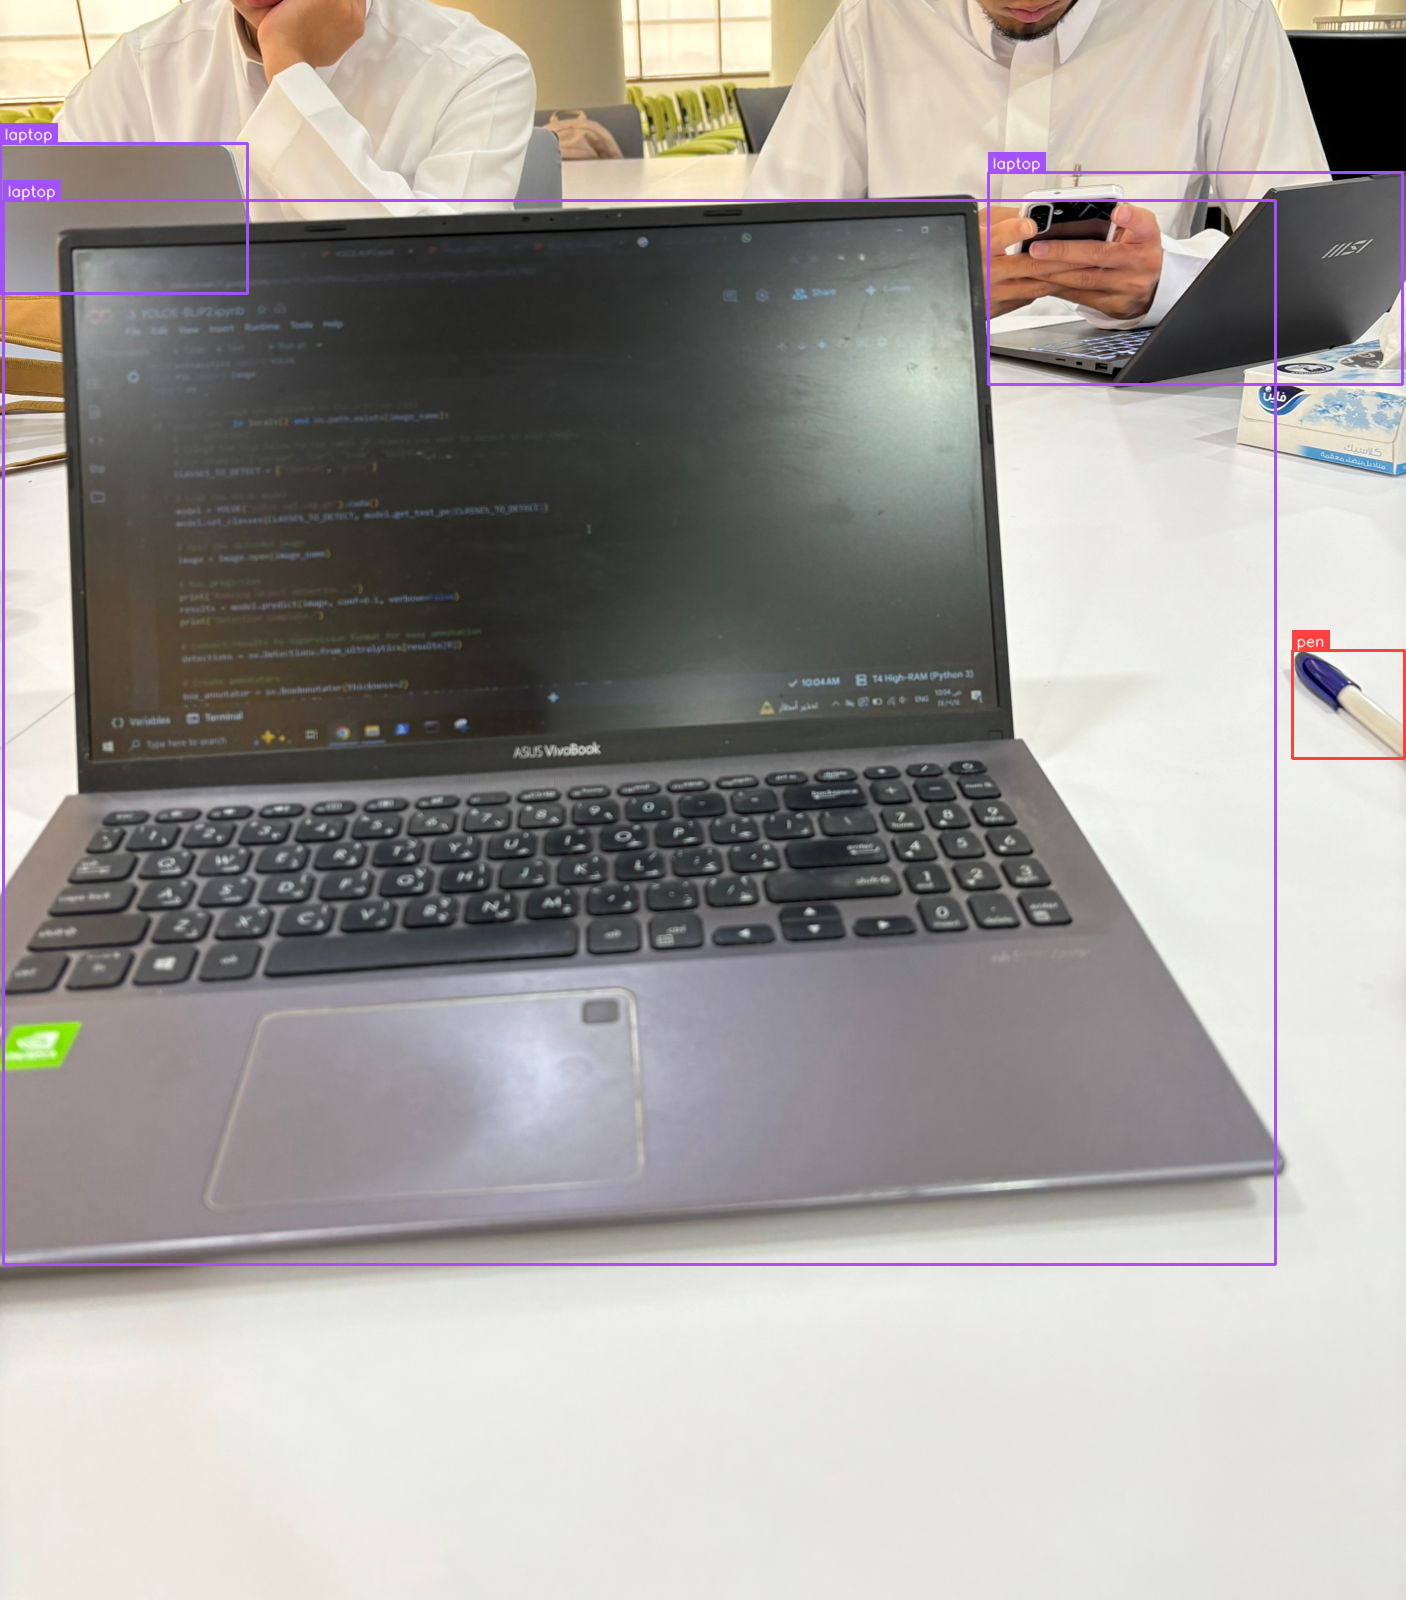

In [ ]:
# Check if an image was uploaded in the previous cell
if 'image_name' in locals() and os.path.exists(image_name):
    # --- IMPORTANT ---
    # Change the list below to the names of objects you want to detect in your image.
    # For example: ["person", "car", "tree", "building"]
    CLASSES_TO_DETECT = ["laptop", "pen"]

    # Load the YOLOE model
    model = YOLOE("yoloe-v8l-seg.pt").cuda()
    model.set_classes(CLASSES_TO_DETECT, model.get_text_pe(CLASSES_TO_DETECT))

    # Open the uploaded image
    image = Image.open(image_name)

    # Run prediction
    print("Running object detection...")
    results = model.predict(image, conf=0.1, verbose=False)
    print("Detection complete.")

    # Convert results to supervision format for easy annotation
    detections = sv.Detections.from_ultralytics(results[0])

    # Create annotators
    box_annotator = sv.BoxAnnotator(thickness=2)
    label_annotator = sv.LabelAnnotator(text_scale=0.5, text_thickness=1, text_padding=4)

    # Annotate the image
    annotated_image = image.copy()
    annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections)
    annotated_image = label_annotator.annotate(
        scene=annotated_image,
        detections=detections,
        # Create labels from the detected class names
        labels=[model.model.names[class_id] for class_id in detections.class_id]
    )

    # Display the final annotated image
    display(annotated_image)

else:
    print("Could not find the uploaded image. Please run the upload cell (Cell 3) again.")



---------------

# 2️⃣ Use BLIP2

## Load the processor and CPU for BLIP2 ~ 1:30 min to install

In [ ]:
processor = AutoProcessor.from_pretrained("Salesforce/blip2-opt-2.7b")
model = Blip2ForConditionalGeneration.from_pretrained("Salesforce/blip2-opt-2.7b", device_map="auto", load_in_8bit=True) # load in int8

processor_config.json:   0%|          | 0.00/68.0 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/432 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/882 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/23.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/10.0G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

## Process image for passing to BLIP2

In [ ]:
file_name = next(iter(uploaded))
image_bytes = uploaded[file_name]
image = Image.open(io.BytesIO(image_bytes)).convert('RGB')

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
inputs = processor(image, return_tensors="pt").to(device, torch.float16)

generated_ids = model.generate(**inputs, max_new_tokens=20)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
print(generated_text)

a laptop sitting on a table with two men sitting in front of it
